# INTRODUCTION



Employee retention is critical for organizations, impacting company performance and the workplace culture. This report will explore the factors influencing an employee's decision to leave a company and building a model that predicts whether an employee leaves or not based on those factors. 

A particular focus has been placed on how demographic factors such as age, gender, and payment tier affect turnover rates.


**Objective:**

This study aims to investigate the following question:
### <center> Is an employee going to leave a company based on age, gender, and salary? </center>



This research will be conducted with reference to existing literature, including "Employee Retention Practices in Hospitality Industry in Nepal: Investigating the Moderating Effect of Management Hierarchy, Age Group and Gender" by Sthapit and Shrestha in 2018 which provide insights into the covariates of interest. By aligning our analysis with these findings, we aim to contribute to the broader understanding of employee turnover and inform organizational practices.

**Background information:**

This study has highlighted that young employees may be more prone to leaving their jobs compared to older employees (Ng et al., 2010). Additionally, the gender dynamics of employee turnover rates are differently distributed between male and female employees. "Women might have different turnover rates compared to men, influenced by organizational support and workplace environment (Hom et al., 2017).

The role of salary as a predictor of employee retention has also been a subject of extensive research. The relationship is complex and may vary depending on other factors such as job satisfaction and career advancement opporunities (Trevor et al., 1997)

## The Data Set

### Employee Retention data set: 
**Source:** https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset?resource=download

**Summary:**
- Number of observations: 4654
- Number of features: 9

**Features:**
- `education`: the degree which each employee obtain.
- `JoiningYear`: year at which the employee join the company.
- `City`: The location or city where each employee is based or works.
- `PaymentTier`: categorization of employees into different salary tiers.
- `Age`: the age of each employee, providing demographic insights.
- `Gender`: gender identity of employees, promoting diversity analysis.
- `EverBenched`: Indicates if an employee has ever been temporarily without assigned work.
- `ExperienceInCurrentDomain`: the number of years of experience employees have in their current field.
- `LeaveOrNot`: whether the employee left the company or not.

**Background:**

The data have been collected from company's HR department in 2018 which provide valuable insights into the workforce while maintaining employees privacy rights.

# METHODS and RESULTS

**Proposed Model: Logistic Regression**

1. **Binary Outcome:** Logistic regression is appropriate for binary response variables which would allow us to estimate the probability of employee retention based on our covariates.

2. **Interpretability:** The coefficients from logistic (logit) provide insights into the odds of the outcome occuring, making it easy to interpret.

3. **Handling Non-linearity:** By using a logistic model, it can model non-linear relationships between the predictors and the probability of the binary outcome.

**Assumptions:**

1. **Linearity of Logits:** The relationship between our covariates and the logit of `LeaveOrNot` should reflect a linear relationship.

 
2. **Independence:** Observations should be independent of each other.


3. **Multicollinearity** Independent variables should not be heavily correlated.


## Loading in the Data

In [40]:
# We first attach any necessary libraries to conduct our exploratory data analysis and modelling
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(AER)
library(GGally)
library(modelr)
library(faraway)
library(MASS)
library(caret)
library(glmnet)
library(ggplot2)
library(MASS)
library(mlbench)
library(ISLR)
library(qqplotr)
library(performance)
library(see)
library(glmbb)
library(dplyr)
library(yardstick)
library(gridExtra)
library(mltools)
library(leaps)
library(rsample)


Warning message:
“package ‘leaps’ was built under R version 4.3.3”


In [8]:
# Demonstrate that the dataset can be read into R
employee <- read_csv("https://drive.google.com/uc?export=download&id=1M7kblkESIbEDBM77F9Iipf8JwR7BYJ0s")

head(employee)

Rows: 4653 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Education, City, Gender, EverBenched
dbl (5): JoiningYear, PaymentTier, Age, ExperienceInCurrentDomain, LeaveOrNot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Bachelors,2017,Bangalore,3,34,Male,No,0,0
Bachelors,2013,Pune,1,28,Female,No,3,1
Bachelors,2014,New Delhi,3,38,Female,No,2,0
Masters,2016,Bangalore,3,27,Male,No,5,1
Masters,2017,Pune,3,24,Male,Yes,2,1
Bachelors,2016,Bangalore,3,22,Male,No,0,0


It was first demonstrated that the Employee Retention dataset can be read into R. For easy collaboration and access without having to modify the read function's file path argument, a Google Drive direct output link was generated to read the dataset directly from an online source.

**Issues:**

Taking a look at our dataset, we can spot a few problems that has to be dealt with before fitting the model:
- `LeaveOrNot`, `Gender`, `EverBenched`, and `PaymentTier` are currently of type double. We will convert these variables into factors to reflect their real-world state
- We will also use the information in `JoiningYear` to calculate the employee's number of years/length of service in that company (`YearsInCompany`). This can be done by substracing their joing year from the year of data collection (which is assumed to be 2018)

## Data Wrangling

In [9]:
# Clean and wrangle your data into a tidy format
employee_clean <- employee %>%  
mutate(LeaveOrNot = as_factor(LeaveOrNot)) %>% 
mutate(Gender = as_factor(Gender)) %>% 
mutate(JoiningYear = 2018 - JoiningYear) %>% 
rename(YearsInCompany = JoiningYear) %>% 
mutate(EverBenched = as_factor(EverBenched)) %>%
mutate(PaymentTier = as_factor(PaymentTier)) 

head(employee_clean)


Education,YearsInCompany,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>
Bachelors,1,Bangalore,3,34,Male,No,0,0
Bachelors,5,Pune,1,28,Female,No,3,1
Bachelors,4,New Delhi,3,38,Female,No,2,0
Masters,2,Bangalore,3,27,Male,No,5,1
Masters,1,Pune,3,24,Male,Yes,2,1
Bachelors,2,Bangalore,3,22,Male,No,0,0


### After modifying the data set, let's take a closer look at the attributes of this data set

In [26]:
# Any summary tables that are relevant to your analysis.
print(paste("Number of rows: " ,nrow(employee_clean)))
print(paste("Number of NAs row: " , sum(is.na(employee_clean))))


retention_proportions <- employee_clean %>%
  count(LeaveOrNot) %>%
  mutate(retention_proportion = n / sum(n))
retention_proportions

payment_tier_proportions <- employee_clean %>%
  count(LeaveOrNot, PaymentTier) %>%
  group_by(LeaveOrNot) %>%
  mutate(proportion_payment = n / sum(n))
payment_tier_proportions

age_gender_yoe_proportions <- employee_clean %>%
  group_by(LeaveOrNot) %>%
  summarise(
    proportion_male = mean(Gender == "Male"),
    average_age = mean(Age))
age_gender_yoe_proportions

employee_clean|>summarize(mean(Gender=='Male'))


[1] "Number of rows:  4653"
[1] "Number of NAs row:  0"


LeaveOrNot,n,retention_proportion
<fct>,<int>,<dbl>
0,3053,0.6561358
1,1600,0.3438642


LeaveOrNot,PaymentTier,n,proportion_payment
<fct>,<fct>,<int>,<dbl>
0,1,154,0.05044219
0,2,368,0.12053718
0,3,2531,0.82902064
1,1,89,0.05562500
1,2,550,0.34375000
1,3,961,0.60062500


LeaveOrNot,proportion_male,average_age
<fct>,<dbl>,<dbl>
0,0.6754012,29.5719
1,0.4475000,29.0525


"mean(Gender == ""Male"")"
<dbl>
0.5970342


With the insights display as digits, it might still be hard to detect and trends in the distribution between covariates. We will visualize them for easier interpretation

## Visualizing the data

### Gender

Warning message in geom_bar(position = "dodge", bins = 8):
“Ignoring unknown parameters: `bins`”


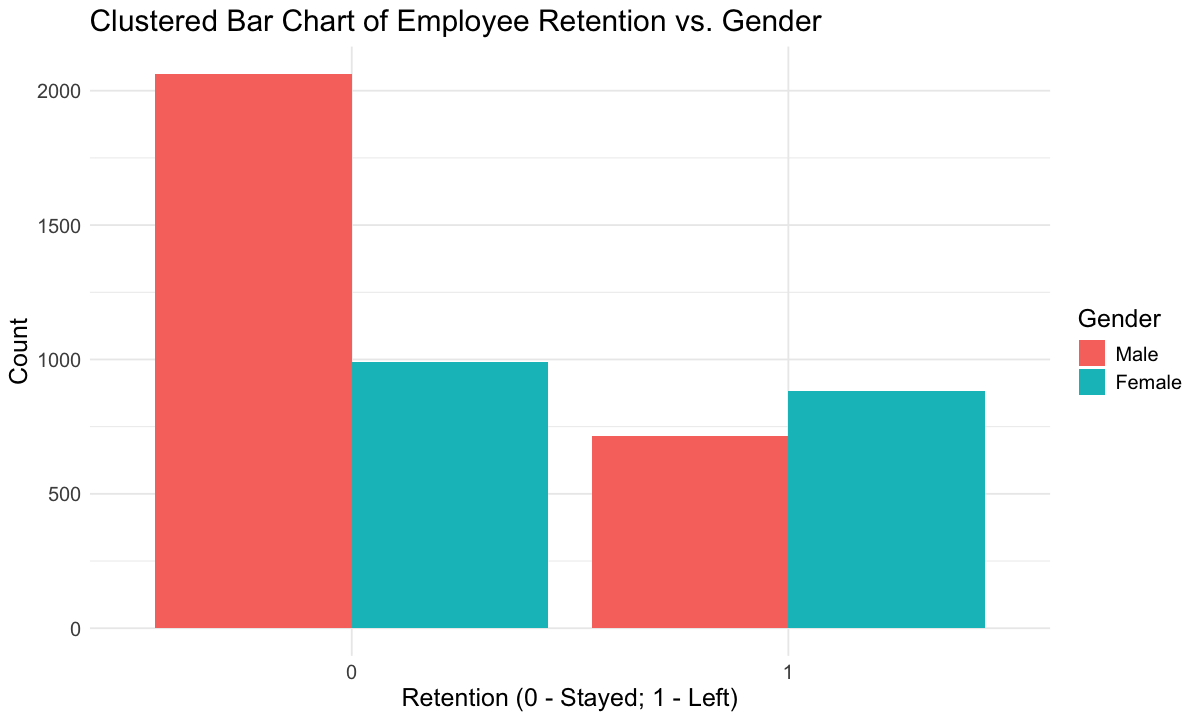

In [28]:
# Plot the relevant raw data, tailoring your plot to address your question.
options(repr.plot.width = 10, repr.plot.height = 6) 

# Clustered Bar Chart of Retention, Filled by Gender
gender_retention_barchart <- 
    employee_clean %>%
    ggplot(aes(LeaveOrNot, 
               fill = Gender)) +
    geom_bar(position = "dodge",
             bins = 8) +
    theme(text = element_text(size = 22)) +
    ggtitle("Clustered Bar Chart of Employee Retention vs. Gender") +
    labs(x = "Retention (0 - Stayed; 1 - Left)", y = "Count", fill = "Gender") +
    theme_minimal() +
    theme(
    text = element_text(size = 15),          
  )
gender_retention_barchart


<center>Figure 1: Rentention vs. Gender distributions</center>

### Salary

Warning message in geom_bar(position = "dodge", bins = 8):
“Ignoring unknown parameters: `bins`”


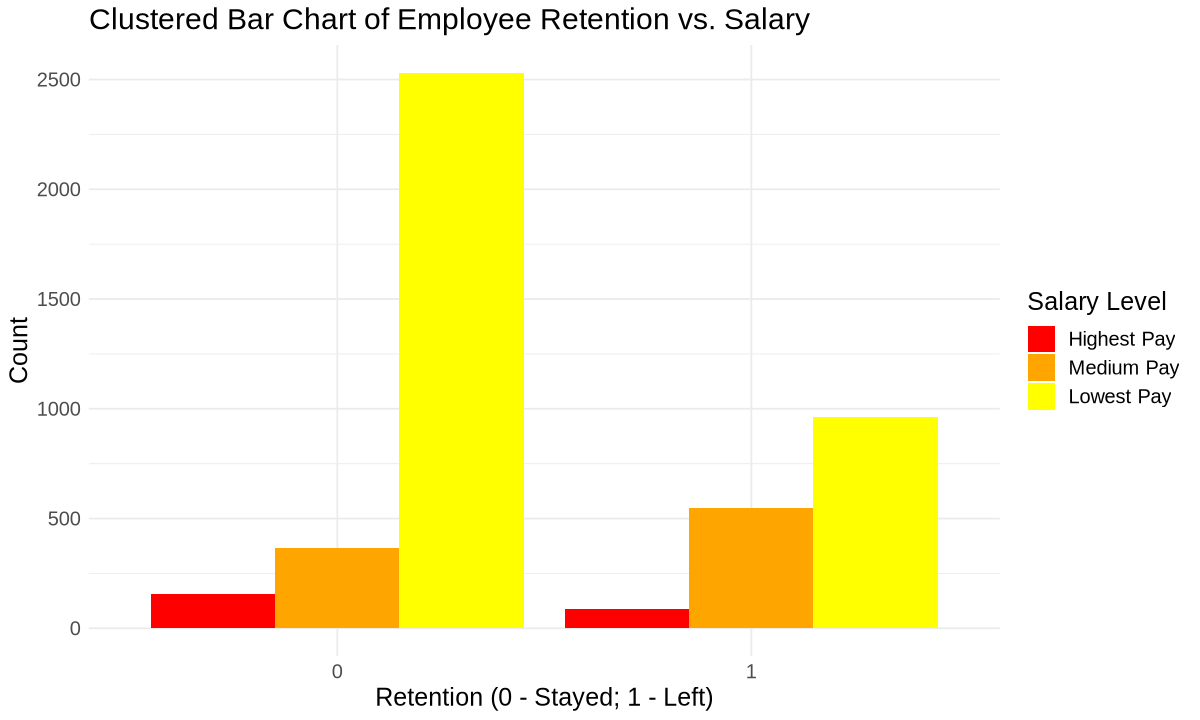

In [118]:
# Clustered Bar Chart of Retention, Filled by Salary
salary_retention_barchart <- 
    employee_clean %>%
    ggplot(aes(LeaveOrNot, 
               fill = PaymentTier)) +
    geom_bar(position = "dodge",
             bins = 8) +
    theme(text = element_text(size = 22)) +
    ggtitle("Clustered Bar Chart of Employee Retention vs. Salary") +
    scale_fill_manual(values = c("red", "orange", "yellow"), labels = c("Highest Pay", "Medium Pay", "Lowest Pay")) +
    labs(x = "Retention (0 - Stayed; 1 - Left)", y = "Count", fill = "Salary Level") +
    theme_minimal() +
    theme(
    text = element_text(size = 15),          
  )
salary_retention_barchart


<center>Figure 2: Retention vs. Payment Tier</center>

### Age

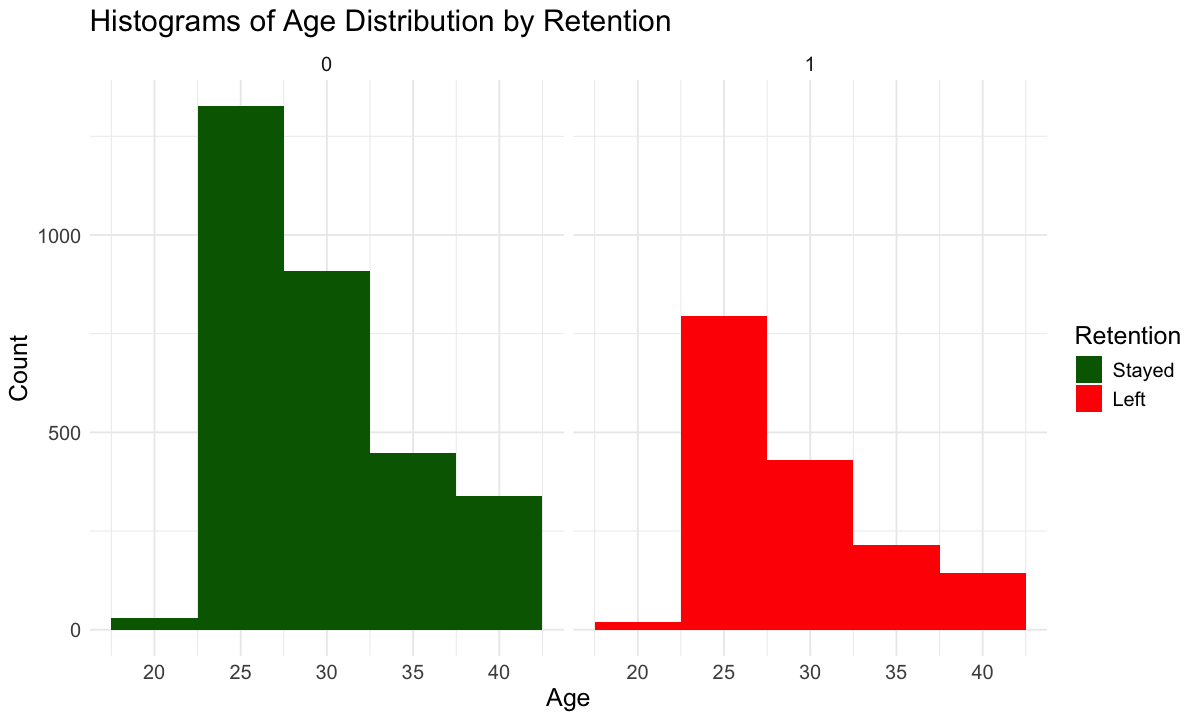

In [30]:
# Side-by-side Histograms of Age Distribution by Retention
age_retention_histogram <- 
    employee_clean %>%
    ggplot(aes(x = Age, fill = as.factor(LeaveOrNot))) +
    geom_histogram(position = "dodge", binwidth = 5) +
    facet_wrap(~LeaveOrNot, scales = "fixed") + 
    scale_fill_manual(values = c("0" = "dark green", "1" = "red"),
                      labels = c("Stayed", "Left")) +
    theme(text = element_text(size = 22)) +
    ggtitle("Histograms of Age Distribution by Retention") +
    labs(x = "Age", y = "Count", fill = "Retention") +
    theme_minimal() +
    theme(
        text = element_text(size = 15)
    )
age_retention_histogram


<center>Figure 3: Retention vs. Age</center>

## Splitting the data set and Fitting the model

- **Setting the seed**: We will set the seed to ensure that the results are reproducible.
- **Spliting the data**: Uses `initial_split` function from the `rsmaple` package to split the data set `employee_clean` with 70% of the data assigned to the training set.
- **Fitting the model**: We will fit a logistic regression model using only the intercept with no predictors to serve as a starting point for forward selection. We will also fit a logistic regression model using all the predictors which represents the most complex model that includes every potential variable
- **Forward Selection:** using `stepAIC` to perform forward selection to pick the best covariates candidates.

In [44]:
set.seed(1)

split<- initial_split(employee_clean,prop=.7,)
training_data<-training(split)
testing_data<-testing(split)


# Fit initial model with only the intercept
intercept_model <- glm(LeaveOrNot ~ 1, family = binomial, data = training_data)
complete_model <- glm(LeaveOrNot ~ ., family = binomial, data = training_data)

# Perform forward selection
selected_model <- stepAIC(intercept_model, 
                          scope = list(lower = intercept_model, upper = complete_model), 
                          direction = "forward", 
                          trace = FALSE)

# View the selected model
(results <- summary(selected_model))


Call:
glm(formula = LeaveOrNot ~ PaymentTier + Gender + City + YearsInCompany + 
    Education + EverBenched + Age + ExperienceInCurrentDomain, 
    family = binomial, data = training_data)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -0.190156   0.334559  -0.568  0.56978    
PaymentTier2               0.788061   0.192378   4.096 4.20e-05 ***
PaymentTier3              -0.031605   0.175743  -0.180  0.85728    
GenderFemale               0.909960   0.084824  10.728  < 2e-16 ***
CityNew Delhi             -0.565955   0.118038  -4.795 1.63e-06 ***
CityPune                   0.569343   0.102826   5.537 3.08e-08 ***
YearsInCompany            -0.163825   0.022862  -7.166 7.73e-13 ***
EducationMasters           0.725931   0.114151   6.359 2.03e-10 ***
EducationPHD               0.008057   0.236772   0.034  0.97285    
EverBenchedYes             0.647920   0.126043   5.140 2.74e-07 ***
Age                       -0.022327   0.008590

## Interpretation

**AIC (Akaike Information Criterion)**: 3674.1, is a measure of the model's quality relative to other models. Lower AIC values indicate a model is more likely to be closer to the truth

Therefore, using the forward-seleciton algorithim, the **inclusion of all 8 variables from our data set yeilds the lowest AIC.**

In [121]:
stepAIC(selected_model) 

Start:  AIC=3674.15
LeaveOrNot ~ PaymentTier + Gender + City + YearsInCompany + Education + 
    EverBenched + Age + ExperienceInCurrentDomain

                            Df Deviance    AIC
<none>                           3650.1 3674.1
- ExperienceInCurrentDomain  1   3653.0 3675.0
- Age                        1   3657.0 3679.0
- EverBenched                1   3676.1 3698.1
- Education                  2   3691.7 3711.7
- YearsInCompany             1   3702.6 3724.6
- PaymentTier                2   3706.0 3726.0
- City                       2   3746.4 3766.4
- Gender                     1   3766.4 3788.4



Call:  glm(formula = LeaveOrNot ~ PaymentTier + Gender + City + YearsInCompany + 
    Education + EverBenched + Age + ExperienceInCurrentDomain, 
    family = binomial, data = training_data)

Coefficients:
              (Intercept)               PaymentTier2  
                -0.190156                   0.788061  
             PaymentTier3               GenderFemale  
                -0.031605                   0.909960  
            CityNew Delhi                   CityPune  
                -0.565955                   0.569343  
           YearsInCompany           EducationMasters  
                -0.163825                   0.725931  
             EducationPHD             EverBenchedYes  
                 0.008057                   0.647920  
                      Age  ExperienceInCurrentDomain  
                -0.022327                  -0.044548  

Degrees of Freedom: 3256 Total (i.e. Null);  3245 Residual
Null Deviance:	    4184 
Residual Deviance: 3650 	AIC: 3674

This shows that 'ExperienceInCurrentDomain' has the smallest AIC which means that the amount of information loss will be the smallest if we remove this variable. 'Gender', meanwhile, will most harm our AIC should we remove it suggesting that it is the most important single covariate when seeking to predict LeaveOrNot, **using our current model.**


### Other evaluation metrics: 

**Cp (Mallows' Cp)** and **BIC (Bayesian Information Criterion)** are both statistical measures used to evaluate the fit of regression model. They help to balance the goodness of fit of the model against its complexity, aiming to identify models that are neither overfit nor underfit

#### Let's calculate these coefficients to reveal some insights about model selection

In [45]:
glm_add<-regsubsets(
   LeaveOrNot~., nvmax=ncol(training_data)-1,
   data=training_data,
   method= 'forward'
 )

glm_add <- summary(glm_add)

summary <- tibble(
    n_input_variables = 1:8,
    RSS = glm_add$rss,
    BIC = glm_add$bic,
    Cp = glm_add$cp
)

summary

n_input_variables,RSS,BIC,Cp
<int>,<dbl>,<dbl>,<dbl>
1,676.7107,-243.9553,314.46347
2,657.5563,-329.3867,215.48567
3,645.9050,-379.5264,156.06288
4,633.1071,-436.6196,90.59535
5,627.8377,-455.7527,64.81635
6,622.4313,-475.8323,38.31478
7,617.1953,-495.2579,12.71197
8,616.0994,-492.9577,8.93457


In [123]:
which.min(fat_fwd_summary$Cp)
which.min(fat_fwd_summary$BIC)

[1] 8

[1] 8

We can see that the inclusion of all **8 variables** `Education`, `YearsInCompany`, `City`, `PaymentTier`, `Age`, `Gender`, `EverBenched`, `ExperienceInCurrentDomain` is still desireable with the new metrics

As an aside: this might be more obvious if we convert our covariates to numerical form. We can do this because our response remains binomial.

In [47]:
employee_num<-employee|>
            mutate(Gender=as.factor(Gender))|>
            mutate(EverBenched=as.factor(EverBenched))|>
            mutate(EverBenched= if_else(EverBenched == "Yes", 1, 0))|>
            mutate(Gender= if_else(Gender== "Male", 1, 0))|>
            mutate(Education=as.factor(Education))|>
            mutate(Education= if_else(Education == "Bachelors", 1, if_else(Education=='Masters',2,3)))|>
            mutate(City= if_else(City == "New Delhi", 1, if_else(Education=='Bangalore',2,3)))


glm_2<-regsubsets(
   LeaveOrNot~., nvmax=ncol(employee_num)-1,
   data=employee_num,
   method= 'backward'
 )

glm_2 <- summary(glm_2)

summary_num<- tibble(
    n_input_variables = 1:8,
    RSS = glm_2$rss,
    BIC = glm_2$bic,
    Cp = glm_2$cp
)

glm_2
summary_num

Subset selection object
Call: regsubsets.formula(LeaveOrNot ~ ., nvmax = ncol(employee_num) - 
    1, data = employee_num, method = "backward")
8 Variables  (and intercept)
                          Forced in Forced out
Education                     FALSE      FALSE
JoiningYear                   FALSE      FALSE
City                          FALSE      FALSE
PaymentTier                   FALSE      FALSE
Age                           FALSE      FALSE
Gender                        FALSE      FALSE
EverBenched                   FALSE      FALSE
ExperienceInCurrentDomain     FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: backward
         Education JoiningYear City PaymentTier Age Gender EverBenched
1  ( 1 ) " "       " "         " "  " "         " " "*"    " "        
2  ( 1 ) " "       "*"         " "  " "         " " "*"    " "        
3  ( 1 ) " "       "*"         " "  "*"         " " "*"    " "        
4  ( 1 ) " "       "*"         "*"  "*"         " " "*"    

n_input_variables,RSS,BIC,Cp
<int>,<dbl>,<dbl>,<dbl>
1,998.6821,-215.4569,403.61882
2,965.0360,-366.4748,235.39387
3,946.3549,-448.9855,142.88052
4,935.3227,-495.1012,89.06584
5,928.2902,-521.7734,55.48600
6,921.9960,-544.9845,25.64224
7,918.7702,-552.8476,11.32165
8,917.9160,-548.7304,9.00000


### Backward selection yields the same results. 

Again, we can see that Gender is selected first and ExperienceInCurrentDomain is selected last. So while Gender is the most important covariate standing alone, ExperienceInCurrentDomain still provides more explanatory power than it might 'cost' in our model.

# DISCUSSION

In [125]:
model<-glm(LeaveOrNot~., family=binomial, data=training_data)

pred<-testing_data|>
            add_predictions(model,var='pred',type='response')

data_pred<-pred|>
            mutate(pred_value=if_else(pred>=.5,1,0))|>
            mutate(pred_value=as.factor(pred_value))

con_matrix <- data_pred|>
            conf_mat(truth = LeaveOrNot, estimate = pred_value)

head(data_pred)
con_matrix



Education,YearsInCompany,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,pred,pred_value
<chr>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>
Bachelors,5,Pune,1,28,Female,No,3,1,0.4283059,0
Bachelors,2,Bangalore,3,22,Male,No,0,0,0.2610353,0
Bachelors,2,Bangalore,3,34,Female,No,2,1,0.3804474,0
Masters,1,New Delhi,2,37,Male,No,2,0,0.4204023,0
Bachelors,0,Pune,3,32,Male,Yes,5,1,0.5145741,1
Bachelors,3,Pune,2,30,Female,No,0,1,0.7142135,1


          Truth
Prediction   0   1
         0 821 286
         1  89 200

# REFERENCES

In [126]:
#